In [1]:
import h5py
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
filename = "/Users/forero/Illustris_data/TNG300-1/groups_099/rL205n2500TNG_Subhalo_3DStellarMasses_099.hdf5"
f = h5py.File(filename, 'r')
keys = list(f.keys())
print(keys)
print(list(f['Subhalo']))
rescaled_stellar_mass = f['Subhalo/StellarMasses_in_Rad'][...]
#rescaled_stellar_mass = f['Subhalo/StellarMasses_in_r10pkpc'][...]
done_field = f['Subhalo/Done'][...]
f.close()

['Header', 'Subhalo']
['Done', 'StellarMasses_in_HalfRad', 'StellarMasses_in_Rad', 'StellarMasses_in_r100ckpc', 'StellarMasses_in_r100pkpc', 'StellarMasses_in_r10ckpc', 'StellarMasses_in_r10pkpc', 'StellarMasses_in_r30ckpc', 'StellarMasses_in_r30pkpc', 'StellarMasses_in_r50ckpc', 'StellarMasses_in_r50pkpc']


In [4]:
print(np.count_nonzero(done_field==1))
print(len(done_field), np.count_nonzero(done_field))

14485709
14485709 14485709


In [25]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"
subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
all_subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)


In [27]:
BoxSize = header['BoxSize']
hubble = header['HubbleParam']
print(BoxSize)

205000.0


In [6]:
halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups

In [28]:
#all_subhalos['stellar_mass'] = rescaled_stellar_mass
all_subhalos['stellar_mass'] = all_subhalos['SubhaloMassType'][:,4]*1E10/hubble

In [29]:
all_subhalos['Halo_mass_M_Mean200'] = halos['Group_M_Mean200'][all_subhalos['SubhaloGrNr']]
all_subhalos['SubhaloID'] = np.arange(len(all_subhalos['SubhaloGrNr']), dtype=int)
ii = all_subhalos['stellar_mass'] > 1.0E10
print(np.count_nonzero(ii))

97233


205000.0


In [30]:
subhalos = all_subhalos.copy()
del subhalos['count']
for k in subhalos.keys():
    subhalos[k] = all_subhalos[k][ii]

In [31]:
print(len(subhalos['SubhaloID']))

97233


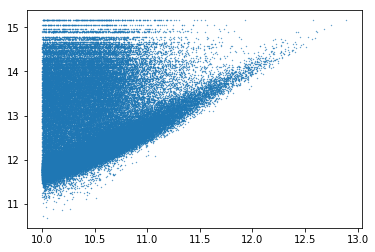

In [32]:
plt.scatter(np.log10(subhalos['stellar_mass']), np.log10(subhalos['Halo_mass_M_Mean200']*1E10), s =0.1)

In [33]:
S_pos = subhalos['SubhaloPos']
S_vel = subhalos['SubhaloVel']
S_vmax = subhalos['SubhaloVmax']
S_stellar_mass = subhalos['stellar_mass']
S_parent_fof = subhalos['Halo_mass_M_Mean200']
S_subhalo_id = subhalos['SubhaloID']
n_S = len(S_pos)
print(n_S)

97233


In [34]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S_pad_pos = S_pos.copy()
S_pad_vel = S_vel.copy()
S_pad_vmax = S_vmax.copy()
S_pad_stellar_mass = S_stellar_mass.copy()
S_pad_fof = S_parent_fof.copy()
S_pad_id = np.arange(n_S)
S_pad_subhalo_id = S_subhalo_id.copy()
for i in [0,1,-1]:
    for j in [0]:
        for k in [0]:
            new_pos = S_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S_pad_pos = np.append(S_pad_pos, new_pos, axis=0)
                S_pad_vel = np.append(S_pad_vel, S_vel, axis=0)
                S_pad_vmax = np.append(S_pad_vmax, S_vmax)
                S_pad_stellar_mass = np.append(S_pad_stellar_mass, S_stellar_mass)
                S_pad_id = np.append(S_pad_id, np.arange(n_S))
                S_pad_fof = np.append(S_pad_fof, S_parent_fof)
                S_pad_subhalo_id = np.append(S_pad_subhalo_id, S_subhalo_id)

In [35]:
nbrs_S = NearestNeighbors(n_neighbors=100, algorithm='ball_tree').fit(S_pad_pos)
dist_S, ind_S = nbrs_S.kneighbors(S_pad_pos)
print(S_pad_pos.shape)
print(dist_S.shape)

(291699, 3)
(291699, 100)


In [36]:
neighbor_index = ind_S[:,1]
neighbor_list = ind_S[:,2:]
print(np.shape(neighbor_list))

n_pairs = 0

halo_A_id = np.empty((0), dtype=int)
halo_B_id = np.empty((0), dtype=int)

for i in range(n_S):
    l = neighbor_index[neighbor_index[i]]% n_S
    j = neighbor_index[i] % n_S
    
    other_j = neighbor_list[i,:] % n_S
    other_l = neighbor_list[neighbor_index[i],:] % n_S
    
    if((i==l) & (not (j in halo_A_id)) & (not (i in halo_B_id)) & (not (j in halo_B_id)) & (not (i in halo_A_id))): # first check to find mutual neighbors
        if((dist_S[i,1]/hubble > 0.0)): #check on the distance between the two galaxies
            stellar_mass_i = S_pad_stellar_mass[i]
            stellar_mass_j = S_pad_stellar_mass[j]
            #mass_limit = min([stellar_mass_i, stellar_mass_j])/10.0
            mass_limit = 0.0
                
            pair_d = dist_S[i,1] # This is the current pair distance
            #dist_limit = pair_d * 4.5 # exclusion radius for massive structures
            #dist_limit = max([3800.0, pair_d * 4.5])
            dist_limit = 3800.0
            massive_close_to_i = any(((dist_S[i,2:]/hubble)<dist_limit) & (S_pad_stellar_mass[other_j] >= mass_limit))
            massive_close_to_j = any(((dist_S[j,2:]/hubble)<dist_limit) & (S_pad_stellar_mass[other_l] >= mass_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)): # check on massive structures inside exclusion radius
                near = ((dist_S[j,2:]/hubble)<dist_limit)
                #tmp_o = S_pad_stellar_mass[other_l]
                #print(mass_limit/1E11, tmp_o[ooo].max()/1E11, np.count_nonzero(ooo), np.max((dist_S[j,2:]/hubble)))
                n_pairs = n_pairs+ 1
                dis = (dist_S[j,2:]/hubble)
                tmp_o = S_pad_stellar_mass[other_l]
                ooo = np.argmax(tmp_o)
                max_near = np.max((dist_S[j,2:]/hubble))
                if((max_near < dist_limit)):
                    print('HEY')
                    print('n near', len(near))
                    print('max nearest distance', max_near)
                    print('distance most massive neighbor',dis[ooo])
                    print(mass_limit/1E11, tmp_o.max()/1E11 )
                    print(dist_limit, S_pad_stellar_mass[other_j].max()/1E12)
                if stellar_mass_i < stellar_mass_j:
                    halo_A_id = np.append(halo_A_id, int(i))
                    halo_B_id = np.append(halo_B_id, int(j))
                else:
                    halo_A_id = np.append(halo_A_id, int(j))
                    halo_B_id = np.append(halo_B_id, int(i))                    
                    #print(pair_d)
print(n_pairs)

(291699, 98)
4772


In [37]:
filename = '../data/pairs_box_L205n2500TNG.hdf5'
print("Started writing data to ", filename)

h5f = h5py.File(filename, 'w')
h5f.create_dataset('subhalo_ID_A', data=S_subhalo_id[halo_A_id])
h5f.create_dataset('subhalo_ID_B', data=S_subhalo_id[halo_B_id])
h5f.create_dataset('subhalo_ID_G', data=S_subhalo_id[:])
h5f.create_dataset('pos_A', data=S_pos[halo_A_id,:]/hubble)
h5f.create_dataset('pos_B', data=S_pos[halo_B_id,:]/hubble)
h5f.create_dataset('pos_G', data=S_pos/hubble)
h5f.create_dataset('vel_A', data=S_vel[halo_A_id,:])
h5f.create_dataset('vel_B', data=S_vel[halo_B_id,:])
h5f.create_dataset('vel_G', data=S_vel)
h5f.create_dataset('vmax_A', data=S_vmax[halo_A_id])
h5f.create_dataset('vmax_B', data=S_vmax[halo_B_id])
h5f.create_dataset('vmax_G', data=S_vmax)
h5f.create_dataset('stellar_mass_A', data=S_stellar_mass[halo_A_id])
h5f.create_dataset('stellar_mass_B', data=S_stellar_mass[halo_B_id])
h5f.create_dataset('stellar_mass_G', data=S_stellar_mass)
h5f.create_dataset('halo_mass_A', data=S_parent_fof[halo_A_id]*1E10/hubble)
h5f.create_dataset('halo_mass_B', data=S_parent_fof[halo_B_id]*1E10/hubble)
h5f.create_dataset('halo_mass_G', data=S_parent_fof*1E10/hubble)
h5f.create_dataset('hubble', data=hubble)
h5f.close()

Started writing data to  ../data/pairs_box_L205n2500TNG.hdf5


In [31]:
# Referencia distancias a M31
# http://adsabs.harvard.edu/abs/2012ApJ...758...11C

# Referencia distancia Cen A
# http://adsabs.harvard.edu/abs/10.1071/AS09061
  
# Distance to M83
# http://adsabs.harvard.edu/abs/2003ApJ...590..256T

In [48]:
Aid= np.array([1410931, 1454692, 1495967 , 1533388, 1914459, 2162906])
Bid = np.array([1410930, 1454691 ,1495966 ,1533389, 1616121, 1695762])

#[1410931 1454692 1495967 1533388 1914459]
#[1410930 1454691 1495966 1533389 1616121]

In [65]:
posiciones = {}
vmax = {}
mass = {}
for i in range(6):
    print(all_subhalos['SubhaloPos'][Aid[i]])
    print(all_subhalos['SubhaloPos'][Bid[i]])
    center = 0.5*(all_subhalos['SubhaloPos'][Aid[i]]+all_subhalos['SubhaloPos'][Bid[i]]) 
    print(center)
    r = np.sqrt(np.sum((all_subhalos['SubhaloPos'] - center)**2, axis=1))
    ii = (r/hubble)<3000
    print(len(r))
    posiciones[i] = all_subhalos['SubhaloPos'][ii]
    vmax[i] = all_subhalos['SubhaloVmax'][ii]
    mass[i] = all_subhalos['stellar_mass'][ii]

[ 21953.707 198045.42  167590.8  ]
[ 21728.092 198320.44  167908.36 ]
[ 21840.898 198182.94  167749.58 ]
14485709
[200992.66   22420.887 118205.805]
[200775.61   22829.951 118347.89 ]
[200884.12   22625.418 118276.84 ]
14485709
[114764.1    36223.438 201194.55 ]
[114427.875  35863.27  201049.95 ]
[114595.984  36043.35  201122.25 ]
14485709
[109087.13  200115.34   68009.664]
[109360.54 200445.64  68237.12]
[109223.836 200280.5    68123.39 ]
14485709
[146630.1  153608.44 140215.25]
[146531.95 153325.9  140629.47]
[146581.03 153467.17 140422.36]
14485709
[102877.65 147490.94  81381.65]
[102626.36 147055.72  81514.52]
[102752.    147273.33   81448.086]
14485709


In [66]:
def plot_pair(pair_id=0):
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    plt.scatter(posiciones[pair_id][:,0], posiciones[pair_id][:,1], s=2, alpha=0.5)
    plt.scatter(posiciones[pair_id][:,0], posiciones[pair_id][:,1], s=mass[pair_id]/1E8, alpha=0.5)
    plt.scatter(all_subhalos['SubhaloPos'][Aid[pair_id]][0],all_subhalos['SubhaloPos'][Aid[pair_id]][1], color='red')
    plt.scatter(all_subhalos['SubhaloPos'][Bid[pair_id]][0],all_subhalos['SubhaloPos'][Bid[pair_id]][1], color='black')

    plt.subplot(1,3,2)
    plt.scatter(posiciones[pair_id][:,2], posiciones[pair_id][:,1], s=2, alpha=0.5)
    plt.scatter(posiciones[pair_id][:,2], posiciones[pair_id][:,1], s=mass[pair_id]/1E8, alpha=0.5)
    plt.scatter(all_subhalos['SubhaloPos'][Aid[pair_id]][2],all_subhalos['SubhaloPos'][Aid[pair_id]][1], color='red')
    plt.scatter(all_subhalos['SubhaloPos'][Bid[pair_id]][2],all_subhalos['SubhaloPos'][Bid[pair_id]][1], color='black')
    
    plt.subplot(1,3,3)
    plt.scatter(posiciones[pair_id][:,2], posiciones[pair_id][:,0], s=2, alpha=0.5)
    plt.scatter(posiciones[pair_id][:,2], posiciones[pair_id][:,0], s=mass[pair_id]/1E8, alpha=0.5)
    plt.scatter(all_subhalos['SubhaloPos'][Aid[pair_id]][2],all_subhalos['SubhaloPos'][Aid[pair_id]][0], color='red')
    plt.scatter(all_subhalos['SubhaloPos'][Bid[pair_id]][2],all_subhalos['SubhaloPos'][Bid[pair_id]][0], color='black')

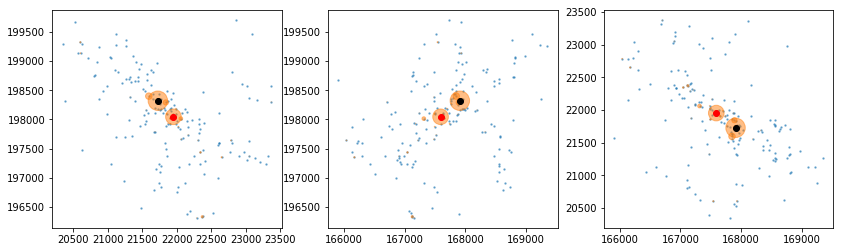

In [67]:
plot_pair(pair_id=0)

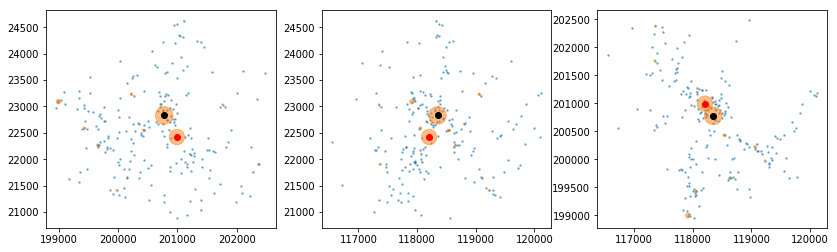

In [68]:
plot_pair(pair_id=1)

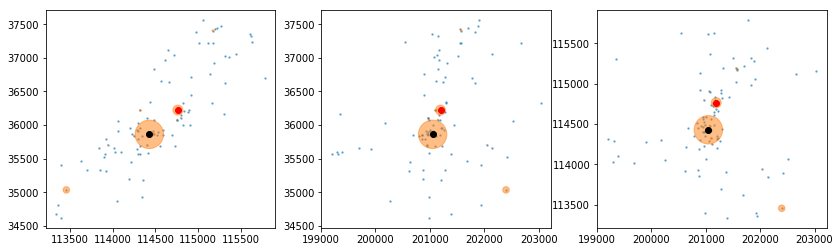

In [69]:
plot_pair(pair_id=2)

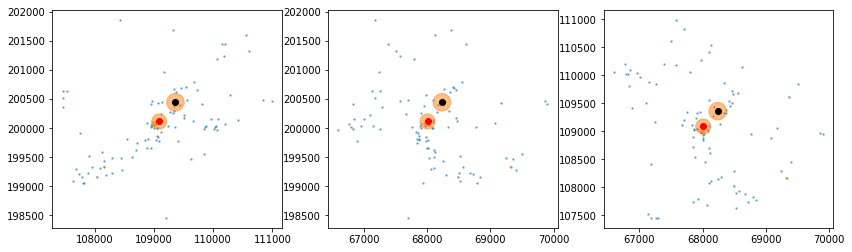

In [70]:
plot_pair(pair_id=3)

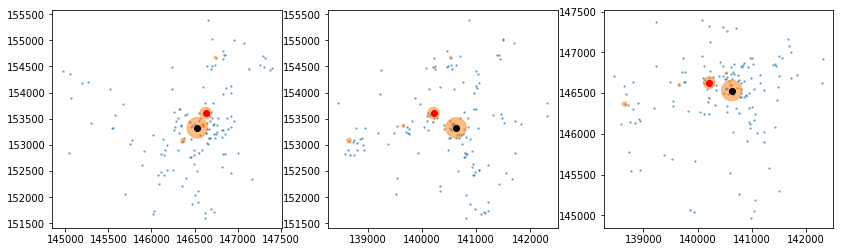

In [71]:
plot_pair(pair_id=4)

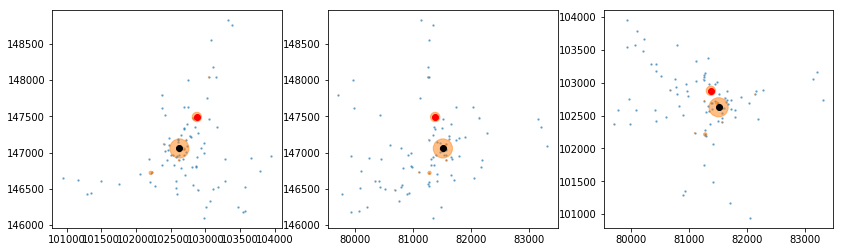

In [72]:
plot_pair(pair_id=5)